In [ ]:
!pip install -qU transformers

In [ ]:
import random
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (
    DataLoader,
    RandomSampler,
    SequentialSampler,
    TensorDataset,
    random_split,
)
from tqdm import tqdm
from tqdm.notebook import tqdm
from transformers import (
    AdamW,
    BertForSequenceClassification,
    BertTokenizer,
    get_linear_schedule_with_warmup,
)

%matplotlib inline
sns.set(color_codes=True)

In [ ]:
df = pd.read_csv("./Filtered_labelled_ge_transcripts (1).csv")
df

,Unnamed: 0,videoId,title,description,published_at,channel,thumbnail_url,transcripts,generated_by_youtube,original_lang,views,comments,likes,pre_processed,entities,Label
0,0,joLk0IPEniA,WILL RAFALE BE A FACTOR THIS ELECTION? | FACEO...,"RafaleTwist DAY BEFORE POLLS, RAFALE BLOW TO G...",2019-04-10T16:41:10Z,CNN-News18,https://i.ytimg.com/vi/joLk0IPEniA/hqdefault.jpg,unanimously rejected government's contention o...,True,en,470,8,5.0,unanimously reject government \n contention ...,Hindu -> NORP\ntoday -> DATE\nSupreme Court ->...,ProGov
1,1,Gc1tf5U7BuU,BJP Manifesto Promises To Secure &amp; Protect...,BattleOf2019 #ElectionsWithNews18 #LokSabhaEle...,2019-04-08T14:19:22Z,CNN-News18,https://i.ytimg.com/vi/Gc1tf5U7BuU/hqdefault.jpg,top story 18 degrees south BJP released manife...,True,en,285,2,9.0,story 18 degree south \n BJP release manifes...,18 -> CARDINAL\nBJP -> ORG\ntoday -> DATE\nsha...,ProGov
2,2,1BAgeFCwR3o,Reporters Project: Andhra Pradesh’s Politics O...,BattleOf2019 #ElectionsWithNews18 #LokSabhaEle...,2019-04-07T09:22:24Z,CNN-News18,https://i.ytimg.com/vi/1BAgeFCwR3o/hqdefault.jpg,[Music] reporters project CNN news 18 reporter...,True,en,1431,3,11.0,reporter project CNN news 18 \n reporter fan...,CNN -> ORG\n18 -> CARDINAL\nApril 11th -> DATE...,ProGov
3,3,HKCBxHhnfC4,Reporters Project: Giving Voice To The Real Is...,BattleOf2019 #ElectionsWithNews18 #LokSabhaEle...,2019-04-07T09:20:19Z,CNN-News18,https://i.ytimg.com/vi/HKCBxHhnfC4/hqdefault.jpg,[Music] reporters project record stories CNN n...,True,en,146,2,2.0,reporter project \n record story CNN news 18...,CNN news -> ORG\n18 -> CARDINAL\nPakistan -> G...,AntiGov
4,4,iLlUz3a4zDg,“I Definitely Don&#39;t Fight A War To Lose” –...,On Off Centre Anuradha SenGupta is talking to ...,2019-04-06T10:28:52Z,CNN-News18,https://i.ytimg.com/vi/iLlUz3a4zDg/hqdefault.jpg,[Music] film stars stranger electoral politics...,True,en,16396,130,205.0,film star stranger electoral \n politic Lok ...,Lok Sabha -> ORG\nyear -> DATE\nLok Sabha -> O...,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259,1363,V1pyuUKGEvw,"CBI Selection Panel To Meet On 24th January, 2019",Republic TV is India's no.1 English news chann...,2019-01-16T12:14:38Z,Republic World,https://i.ytimg.com/vi/V1pyuUKGEvw/hqdefault.jpg,breaking news coming far entire internal battl...,True,en,361,0,4.0,breaking news come far \n entire internal ba...,CBI -> ORG\nCBI -> ORG\nAlok Varma -> PERSON\n...,Neutral
1260,1364,qx0a2coAYz4,Church Body&#39;s Letter Accessed By Republic ...,Republic TV is India's no.1 English news chann...,2019-01-16T11:29:33Z,Republic World,https://i.ytimg.com/vi/qx0a2coAYz4/hqdefault.jpg,Oh leave convent editor dungeon fact official ...,True,en,705,6,19.0,oh leave convent editor \n dungeon fact offi...,Jesus -> PERSON\nAlfea -> PERSON\nJesus -> PER...,Neutral
1261,1365,OVUMiE3tCc8,Four Nuns Who Spoke Against Franco Mulakkal Sh...,Republic TV is India's no.1 English news chann...,2019-01-16T11:15:26Z,Republic World,https://i.ytimg.com/vi/OVUMiE3tCc8/hqdefault.jpg,pull away uh breaking update Santa Fe's gettin...,True,en,16305,47,104.0,pull away uh break \n update Santa Fe gettin...,Santa Fe -> ORG\nFranco -> PERSON\nKerala -> G...,AntiGov
1262,1366,mF09iL30OCY,"After Being Dumped By SP-BSP, Rahul Gandhi For...",Republic TV is India's no.1 English news chann...,2019-01-15T06:14:38Z,Republic World,https://i.ytimg.com/vi/mF09iL30OCY/hqdefault.jpg,let's quickly turn attention Congress party sn...,True,en,364,3,6.0,let quickly turn attention \n Congress party...,Congress -> ORG\nAkhilesh Yadav -> PERSON\nnot...,Neutral


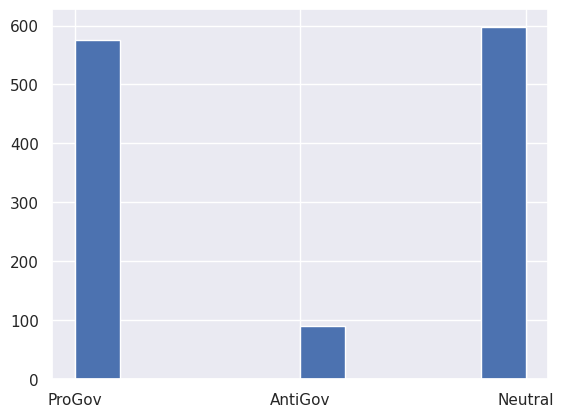

In [ ]:
categorical_label = pd.Series(df["Label"], dtype="category")
pd.factorize(categorical_label)
plt.hist(categorical_label);

In [ ]:
df.head()

,Unnamed: 0,videoId,title,description,published_at,channel,thumbnail_url,transcripts,generated_by_youtube,original_lang,views,comments,likes,pre_processed,entities,Label
0,0,joLk0IPEniA,WILL RAFALE BE A FACTOR THIS ELECTION? | FACEO...,"RafaleTwist DAY BEFORE POLLS, RAFALE BLOW TO G...",2019-04-10T16:41:10Z,CNN-News18,https://i.ytimg.com/vi/joLk0IPEniA/hqdefault.jpg,unanimously rejected government's contention o...,True,en,470,8,5.0,unanimously reject government \n contention ...,Hindu -> NORP\ntoday -> DATE\nSupreme Court ->...,ProGov
1,1,Gc1tf5U7BuU,BJP Manifesto Promises To Secure &amp; Protect...,BattleOf2019 #ElectionsWithNews18 #LokSabhaEle...,2019-04-08T14:19:22Z,CNN-News18,https://i.ytimg.com/vi/Gc1tf5U7BuU/hqdefault.jpg,top story 18 degrees south BJP released manife...,True,en,285,2,9.0,story 18 degree south \n BJP release manifes...,18 -> CARDINAL\nBJP -> ORG\ntoday -> DATE\nsha...,ProGov
2,2,1BAgeFCwR3o,Reporters Project: Andhra Pradesh’s Politics O...,BattleOf2019 #ElectionsWithNews18 #LokSabhaEle...,2019-04-07T09:22:24Z,CNN-News18,https://i.ytimg.com/vi/1BAgeFCwR3o/hqdefault.jpg,[Music] reporters project CNN news 18 reporter...,True,en,1431,3,11.0,reporter project CNN news 18 \n reporter fan...,CNN -> ORG\n18 -> CARDINAL\nApril 11th -> DATE...,ProGov
3,3,HKCBxHhnfC4,Reporters Project: Giving Voice To The Real Is...,BattleOf2019 #ElectionsWithNews18 #LokSabhaEle...,2019-04-07T09:20:19Z,CNN-News18,https://i.ytimg.com/vi/HKCBxHhnfC4/hqdefault.jpg,[Music] reporters project record stories CNN n...,True,en,146,2,2.0,reporter project \n record story CNN news 18...,CNN news -> ORG\n18 -> CARDINAL\nPakistan -> G...,AntiGov
4,4,iLlUz3a4zDg,“I Definitely Don&#39;t Fight A War To Lose” –...,On Off Centre Anuradha SenGupta is talking to ...,2019-04-06T10:28:52Z,CNN-News18,https://i.ytimg.com/vi/iLlUz3a4zDg/hqdefault.jpg,[Music] film stars stranger electoral politics...,True,en,16396,130,205.0,film star stranger electoral \n politic Lok ...,Lok Sabha -> ORG\nyear -> DATE\nLok Sabha -> O...,Neutral


In [ ]:
labels = categorical_label
text = df.transcripts.values

In [ ]:
numerical_labels = [["ProGov", "Neutral", "AntiGov"].index(a) for a in categorical_label]

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [ ]:
input_ids = []
attention_mask = []
for i in text:
    encoded_data = tokenizer.encode_plus(
        i,
        add_special_tokens=True,
        max_length=64,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    input_ids.append(encoded_data["input_ids"])
    attention_mask.append(encoded_data["attention_mask"])
input_ids = torch.cat(input_ids, dim=0)
attention_mask = torch.cat(attention_mask, dim=0)
labels = torch.tensor(numerical_labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
dataset = TensorDataset(input_ids, attention_mask, labels)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print("Training Size - ", train_size)
print("Validation Size - ", val_size)

Training Size -  884
Validation Size -  380


In [ ]:
train_dl = DataLoader(
    train_dataset, sampler=RandomSampler(train_dataset), batch_size=16
)
val_dl = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=16)

In [ ]:
len(train_dl), len(val_dl)

(56, 24)

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(device)

cuda


In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 10
total_steps = len(train_dl) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

In [ ]:
def accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat == label_flat) / len(label_flat)

In [ ]:
def evaluate(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs["labels"].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    return loss_val_avg, predictions, true_vals

In [ ]:
accuracies = []
val_losses = []
train_losses = []


torch.cuda.empty_cache()
for epoch in tqdm(range(1, epochs + 1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(train_dl, desc=f"Epoch {epoch:1d}", leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
            "labels": batch[2],
        }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({"training_loss": f"{loss.item() / len(batch):.3f}"})

    tqdm.write(f"\nEpoch {epoch}")

    loss_train_avg = loss_train_total / len(train_dl)
    tqdm.write(f"Training loss: {loss_train_avg}")
    train_losses.append(loss_train_avg)

    _, train_predictions, true_train_vals = evaluate(train_dl)
    val_loss, predictions, true_vals = evaluate(val_dl)
    train_acc = accuracy(train_predictions, true_train_vals)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f"Validation loss: {val_loss}")
    val_losses.append(val_loss)
    tqdm.write(f"Accuracy: {train_acc} {val_acc}")
    accuracies.append(val_acc)

print(accuracies)
print(val_losses)
print(train_losses)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9182426471795354
Validation loss: 0.8960011502106985
Accuracy: 0.5938914027149321 0.5052631578947369


Epoch 2:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8555549925991467
Validation loss: 0.8749026780327162
Accuracy: 0.7002262443438914 0.5526315789473685


Epoch 3:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.8174922657864434
Validation loss: 0.8523345763484637
Accuracy: 0.7579185520361991 0.6026315789473684


Epoch 4:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.7354275515036923
Validation loss: 0.8490961318214735
Accuracy: 0.8099547511312217 0.5921052631578947


Epoch 5:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.6571037018937724
Validation loss: 0.8957914809385935
Accuracy: 0.8631221719457014 0.5526315789473685


Epoch 6:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.5818807019719056
Validation loss: 0.9190119480093321
Accuracy: 0.8936651583710408 0.5631578947368421


Epoch 7:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.5340723421956811
Validation loss: 0.994125579794248
Accuracy: 0.8947963800904978 0.55


Epoch 8:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.4903554192611149
Validation loss: 0.9448304797212282
Accuracy: 0.9083710407239819 0.5657894736842105


Epoch 9:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.45097228911306175
Validation loss: 0.9366771032412847
Accuracy: 0.9128959276018099 0.5763157894736842


Epoch 10:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.44281489215791225
Validation loss: 0.9613454441229502
Accuracy: 0.915158371040724 0.5684210526315789
[0.5052631578947369, 0.5526315789473685, 0.6026315789473684, 0.5921052631578947, 0.5526315789473685, 0.5631578947368421, 0.55, 0.5657894736842105, 0.5763157894736842, 0.5684210526315789]
[0.8960011502106985, 0.8749026780327162, 0.8523345763484637, 0.8490961318214735, 0.8957914809385935, 0.9190119480093321, 0.994125579794248, 0.9448304797212282, 0.9366771032412847, 0.9613454441229502]
[0.9182426471795354, 0.8555549925991467, 0.8174922657864434, 0.7354275515036923, 0.6571037018937724, 0.5818807019719056, 0.5340723421956811, 0.4903554192611149, 0.45097228911306175, 0.44281489215791225]


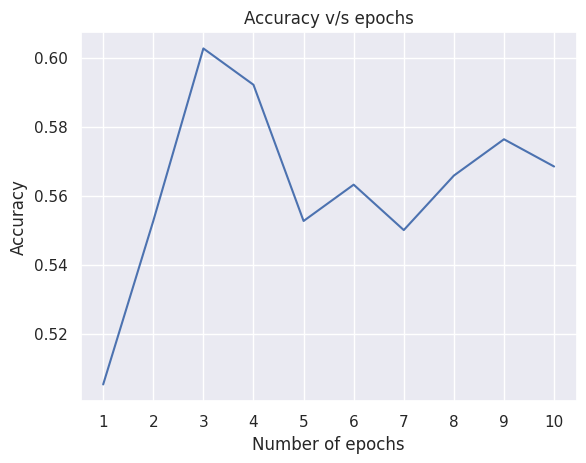

In [ ]:
epochs_val = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.plot(epochs_val, accuracies)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy v/s epochs")
# plt.ylim(0.94, 0.96)
plt.xticks(epochs_val)
plt.savefig("accuracy.png")

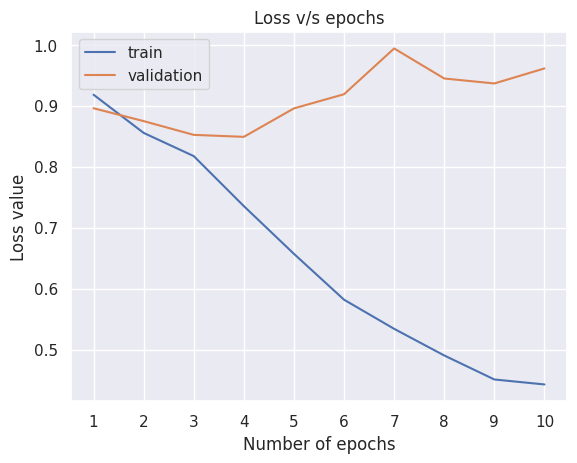

In [ ]:
plt.plot(epochs_val, train_losses, epochs_val, val_losses)
plt.xlabel("Number of epochs")
plt.ylabel("Loss value")
plt.title("Loss v/s epochs")
# plt.ylim(0.94, 0.96)
plt.xticks(epochs_val)
plt.legend(["train", "validation"])
plt.savefig("losses.png")

In [ ]:
output_dir = "./"
model_to_save = model.module if hasattr(model, "module") else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

In [ ]:
# Load the BERT tokenizer.
print("Loading BERT tokenizer...")
output_dir = "./"
tokenizer = BertTokenizer.from_pretrained(output_dir)
model_loaded = BertForSequenceClassification.from_pretrained(output_dir)

Loading BERT tokenizer...


In [ ]:
def Sentiment(sent):
    output_dir = "./"
    tokenizer = BertTokenizer.from_pretrained(output_dir)
    model_loaded = BertForSequenceClassification.from_pretrained(output_dir)
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens=True,
        max_length=64,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    input_id = encoded_dict["input_ids"]

    attention_mask = encoded_dict["attention_mask"]
    input_id = torch.LongTensor(input_id)
    attention_mask = torch.LongTensor(attention_mask)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_loaded = model_loaded.to(device)
    input_id = input_id.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model_loaded(
            input_id, token_type_ids=None, attention_mask=attention_mask
        )

    logits = outputs[0]
    index = logits.argmax()
    return index

In [ ]:
Sentiment("BJP")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


tensor(1, device='cuda:0')

In [ ]:
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input.to(device))

In [ ]:
output

SequenceClassifierOutput(loss=None, logits=tensor([[-0.5023,  1.3332, -0.0822]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
from transformers import pipeline

In [ ]:
unmasker = pipeline('fill-mask', model=model.to(device), tokenizer=tokenizer)

In [ ]:
unmasker("Hello I'm a [MASK] model.")

RuntimeError: ignored